# Practical Session 4: Getting Started with Deep Learning Models in TensorFlow

*This notebook is based on past years' notebooks by Marek Rei and Guy Emerson*

This practical will cover a few different network architectures and we will look at different components that are often used in neural networks in practice. It will also allow you to learn more about [`TensorFlow`](https://www.tensorflow.org), a popular open-source machine learning and deep learning library. I'd also recommend checking the `TensorFlow` documentation to learn more about the rich functionality of this toolkit.


## Learning objectives

In this practical you will learn about:
- The basics of running `TensorFlow` 
- How to implement a feedforward neural network in Python
- How to visualise your network architecture using `TensorBoard` and track changes 
- How to apply deep learning to both classification and regression tasks.

**Additional references**: Aurelien Geron, *Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow*.

Before we start, let's import the usual libraries as we did in previous practicals:

In [ ]:
%matplotlib inline 

import numpy as np 
np.random.seed(42)

import matplotlib
from matplotlib import pyplot as plt

Now let's import `TensorFlow` into our notebook. Note: `TensorFlow` v2 was released last year, and it mostly relies on `Keras` interpretative module fit on top of it. As a result, it is much more interpretable and user-friendly than v1, however if you want to better understand the inner workings of `TensorFlow` you are welcome to check the accompanying notebook [`DSPNP_practical4-TFv1.ipynb`](./DSPNP_practical4-TFv1.ipynb): even if you are using `TensorFlow2`, you can still switch to using v1 API, which is available as a submodule. 

In [ ]:
import tensorflow as tf
#tf.compat.v1

In [ ]:
tf.__version__

# Minimal TensorFlow Example

In this example, we create a simple network that takes an input vector, multiplies it by a weight matrix, adds a weight vector, and returns the result.

`tf.Variable` defines model parameters, which can be trained (as we will see shortly). Here, we initialise the matrix variable as a 3x3 matrix, with every entry as 1 (`tf.ones`). Meanwhile, we initialise the 3x1 vector variable with every entry as 0 (`tf.zeros`). `tf.linalg.matvec` multiplies a matrix and a vector.

In [ ]:
weight_matrix = tf.Variable(tf.ones(shape=(3,3)))
weight_vector = tf.Variable(tf.zeros(shape=(3,)))

def affine_transformation(input_vector):
    return tf.linalg.matvec(weight_matrix, input_vector) + weight_vector

result = affine_transformation([2.,3.,7.])
print(result)

The following [reset function](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) is often useful. It is necessary to reset the `TensorFlow` network from time to time: as we have many different small networks in one notebook and we don't want them interfering with each other, as a pre-emptive measure we will occasionally reset the computation graph. 

In [ ]:
tf.keras.backend.clear_session()

# Training the Parameters

This example shows how to optimise the parameters in your model.

We first define a network that takes an input vector, multiplies it with a matrix (as defined above), and sums the elements of the resulting vector (using `tf.math.reduce_sum`). We then define a loss function as the square error. Given a specific input and output, we can calculate the loss of applying the network to the input.

Next, we define an optimiser – here, we are using *stochastic gradient descent* (*SGD*) with the learning rate $0.001$. We then use this optimiser to train this network for $10$ epochs, over this single training point. This optimises the output towards the target value $20$. Printing out the results, we can see that the output gradually moves towards the target.

In [ ]:
tf.keras.backend.clear_session()

weight_matrix = tf.Variable(tf.ones(shape=(3,3)))
weight_vector = tf.Variable(tf.zeros(shape=(3,)))

def network(input_vector):
    return tf.math.reduce_sum(affine_transformation(input_vector))

def loss_fn(predicted, gold):
    return tf.square(predicted - gold)

input = [2.,3.,7.]
gold_output = 20

def loss():
    return loss_fn(network(input), gold_output)

opt = tf.keras.optimizers.SGD(learning_rate=0.001)

for epoch in range(10):
    opt.minimize(loss, var_list=[weight_matrix, weight_vector])
    print(network(input))

**Optional**: Try changing the learning rate and the number of epochs. What results are you getting?

# Network Layers

For most cases, we don't actually need to create the trainable variables manually. Instead, the feedfoward layer is available as a pre-defined module.

We can define a network as a sequence of operations, using [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential). The first operation here is a dense feedforward layer (`tf.keras.layers.Dense`), which acts like the `affine_transfomation` function we defined earlier. The second operation sums the elements of the vector – this isn't a standard operation, so we use `tf.keras.layers.Lambda` to allow a user-defined function.

By default, the parameters in a layer (like [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) are initialised randomly.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_shape=(3,)),
    tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, axis=1))
])

Note that such a model expects the input data to be given as a *minibatch* – this means that the input tensor should have an extra index, which ranges over datapoints. In our case, instead of passing a 3-dimensional input vector, we have to pass an Nx3 matrix, where N is the number of datapoints. Here, we can apply the model to a single datapoint (a 1x3 matrix):

In [ ]:
model.predict(tf.constant([[2.,3.,7.]]))

Now that we have a model defined in terms of layers, let's replace the manually created variables of the previous section.

In [ ]:
tf.keras.backend.clear_session

model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_shape=(3,)),
    tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x, axis=1))
])

def loss_fn(predicted, gold):
    return tf.square(predicted - gold)

input = tf.constant([[2.,3.,7.]])
gold_output = 20

def loss():
    return loss_fn(model(input), gold_output)

opt = tf.keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(10):
    opt.minimize(loss, var_list=model.trainable_variables)
    print(model(input))

In fact, for standard optimizers and loss functions, the `TensorFlow` API makes it even easier for us:

In [ ]:
tf.keras.backend.clear_session

model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_shape=(3,)),
    tf.keras.layers.Lambda(lambda x: tf.math.reduce_sum(x))
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), # alternatively, optimizer=`sgd`
              loss='mean_squared_error')

input = tf.constant([[2.,3.,7.]])
gold_output = tf.constant([[20.]])

for epoch in range(10):
    model.train_on_batch(input, gold_output)
    print(model(input))

# Activation Functions

As you saw in the previous lectures, activation functions are what gives neural networks their power to model non-linear patterns in the data. After applying an affine transformation, we then apply a non-linear activation function to each element. There are a number of different activation functions to choose from.

The [sigmoid function](https://en.wikipedia.org/wiki/Logistic_function), also known as the logistic function, is the most classic non-linear activation. It transforms the value to a range between 0 and 1.

In [ ]:
hidden = tf.keras.layers.Dense(100, activation='sigmoid')

In modern networks, the [tanh function](https://en.wikipedia.org/wiki/Hyperbolic_function) is used more often. It has more flexibility, as it transforms the input value to a range between -1 and 1, and can therefore output negative values as well.

In [ ]:
hidden = tf.keras.layers.Dense(100, activation='tanh')

Another popular one is the [Rectified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function, or the ReLU. This function acts as a linear function above zero, but restricts everything below zero to 0. By doing this it also introduces non-linearity.

In [ ]:
hidden = tf.keras.layers.Dense(100, activation='relu')

The partial linear property of the ReLU can help it converge faster on some tasks, although in practice tanh may be a more robust option.

Finally, for classification tasks [softmax](https://en.wikipedia.org/wiki/Softmax_function) is an important activation function. Unlike the activation functions mentioned above, it isn't applied to each element separately. It converts a vector of scores into a probability distribution: after applying the softmax, all values are between 0 and 1, and together they sum to 1. Higher scores are assigned to higher probabilities, via the formula:

<center>
$P(i) \propto \exp(x_i)$
</center>

Or, more explicitly:

<center>
$P(i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$
</center>

Notice how the value of the denominator depends on all other values.

The softmax is often used in the output layer of a network performing classification, in order to predict a probability distribution over all the possible classes. For example, the following model takes a 20-dimensional input, maps it to a 50-dimensional hidden layer, then maps it to a distribution over 10 output classes.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, input_shape=(20,), activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Operations and Useful Functions

`TensorFlow` has corresponding versions of all the main operations you might want to use. This means you can add them into your computation graph and into your neural network. The most common operations are available in `tf`, and further operations are available in `tf.math`.


In [ ]:
tf.abs # absolute value
tf.negative # computes the negative value
tf.sign # returns 1, 0 or -1 depending on the sign of the input
tf.math.reciprocal # reciprocal 1/x
tf.square # return input squared
tf.round # return rounded value
tf.sqrt # square root
tf.math.rsqrt # reciprocal of square root
tf.pow # power
tf.exp # exponential

These operations can be applied to scalar values, but also to vectors, matrices and higher-order tensors. In the latter case, they will be applied element-wise. For example:

In [ ]:
print(tf.negative([3.2,-2.7]))
print(tf.square([1.5,-2.1]))

Some useful operations are performed over a whole vector/matrix tensor and return a single value (e.g., you saw `tf.reduce_sum` earlier):

In [ ]:
tf.reduce_sum # Add elements together
tf.reduce_mean # Average over elements
tf.reduce_min # Minimum value
tf.reduce_max # Maximum value
tf.argmax # Index of the largest value
tf.argmin # Index of the smallest value

# Adaptive Learning Rates

Above, we used stochastic gradient descent (SGD) to train our model. This uses a fixed learning rate to update the parameters. Several optimisation algorithms are based on SGD, but adaptively adjust the learning rate (usually for each parameter separately).

Different adaptive learning rate strategies are also implemented in `TensorFlow` as functions. For example:

In [ ]:
tf.keras.optimizers.SGD
tf.keras.optimizers.Adadelta
tf.keras.optimizers.Adam
tf.keras.optimizers.RMSprop

If you are interested in the differences between these strategies, [this blog post](http://ruder.io/optimizing-gradient-descent/) provides more details.

# Training an XOR Function

[XOR](https://en.wikipedia.org/wiki/XOR_gate) is the function that takes two binary values and returns 1 only if one of them is 1 and the other 0, while returning 0 if both of them have the same value. It can be a difficult function to learn and cannot be modelled with a linear model. But let's try anyway.

Our dataset consists of all the possible different states that XOR can take:

In [ ]:
xor_input = tf.constant([[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0]])
xor_output = tf.constant([0.0, 1.0, 1.0, 0.0])

Now we construct a linear network and optimize it on this dataset, printing out the predictions at each epoch:

In [ ]:
tf.keras.backend.clear_session

linear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=(2,))
])

linear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
                     loss='mean_squared_error')

for epoch in range(100):
    linear_model.train_on_batch(xor_input, xor_output)
    if (epoch + 1) % 10 == 0:
        print('after {} epochs:'.format(epoch+1), linear_model(xor_input).numpy().reshape((4,)))

As you can see, it's not doing very well. Ideally, the predictions should be [0, 1, 1, 0], but in this case they are hovering around 0.5 for every input case.

In order to improve this architecture, let's add some non-linear layers into our model:

In [ ]:
tf.keras.backend.clear_session

nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, input_shape=(2,), activation='tanh'), # note that these settings can be changed
    tf.keras.layers.Dense(1, activation='sigmoid')
])

nonlinear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
                        loss='mean_squared_error')

for epoch in range(100):
    nonlinear_model.train_on_batch(xor_input, xor_output)
    if (epoch + 1) % 10 == 0:
        print('after {} epochs:'.format(epoch+1), nonlinear_model(xor_input).numpy().reshape((4,)))

This is much better. The values are much closer to [0, 1, 1, 0] than before, and they will continue improving if we train for longer. (Remember that the model is initialised randomly – if you run it a few times, you will see that the results vary with each run. Check the [documentation](https://www.tensorflow.org/tutorials/keras/save_and_load) on how you can save and restore a particular model).

We also had to increase the learning rate for this network. It would still be learning with a smaller learning rate, but it would be converging very slowly. As we discussed in the lectures, learning rate is a hyperparameter that can vary quite a bit depending on the network architecture and dataset.

**Optional**: Try changing various settings in the current network, e.g. *width* (number of neurons per layer), *depth* (number of layers), *activation functions* applied to each layer, and number of *epochs*. What changes do you observe?

# XOR Classification

We can also do classification with `TensorFlow`. For this, we often use the softmax activation function described above, which predicts the probability for each of the possible classes.

We also have to change the loss function, as squared error is not suitable for classification. A suitable loss function is [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy). Since the correct output has probability 1 for the correct class, and probability 0 for the rest, minimising cross entropy is the same as minimising the negative log probability of the correct class for each datapoint. In other words, by minimising cross entropy, we are trying to find the maximum likelihood model, which assigns high values for the correct label.

We can change the XOR example above to perform classification instead. In this case, we are constructing a binary classifier – choosing between the classes of 0 and 1. The output here prints the predicted probabilities of the two classes.

In [ ]:
tf.keras.backend.clear_session

nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

nonlinear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
                        loss='sparse_categorical_crossentropy')

for epoch in range(50):
    nonlinear_model.train_on_batch(xor_input, xor_output)
    if (epoch + 1) % 10 == 0:
        print('after {} epochs:'.format(epoch+1), nonlinear_model(xor_input).numpy(), sep='\n')

Let's convert these probabilities into class predictions and also report some of the more familiar [evaluation metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics), e.g. *accuracy*:

In [ ]:
tf.keras.backend.clear_session()

nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

nonlinear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])  

for epoch in range(50):
    nonlinear_model.train_on_batch(xor_input, xor_output)
    predictions = nonlinear_model.predict(xor_input)
    result = tf.argmax(predictions, axis=1)
    
    if (epoch + 1) % 10 == 0:
        print('\nAfter {} epochs:'.format(epoch+1), " ".join([str(x) for x in result.numpy()]))
        test_loss, test_acc = nonlinear_model.evaluate(xor_input, xor_output, verbose=2)
        print('\nAccuracy:', test_acc)


You should be able to see in this printout that the model starts off with incorrect predictions, but fairly soon learns to return the correct sequence of [0, 1, 1, 0].

Finally, here is how you can print out the confusion matrix. Since we are looking into a simple case here and the predictions from above are quite accurate, there is not much to be learned from the confusion matrix at this point (but note that this functionality may come in handy later in your practical):

In [ ]:
conf_mx = tf.math.confusion_matrix(xor_output, result.numpy()).numpy()
print(conf_mx)

# Minibatching

For the XOR data, there are only 4 datapoints. However, with realistic datasets, it is inefficient to train on the whole dataset at once, because this will require a lot of computation in order to make a single update step. 

Instead, we can train on a batch of data at a time. For example, here is how you can take batches of 2 datapoints for the XOR data:

In [ ]:
tf.keras.backend.clear_session

nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

nonlinear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
                        loss='sparse_categorical_crossentropy')

BATCH_SIZE = 2

for epoch in range(50):
    for i in range(0,len(xor_input),BATCH_SIZE):
        input_batch = xor_input[i:i+BATCH_SIZE]
        output_batch = xor_output[i:i+BATCH_SIZE]
        nonlinear_model.train_on_batch(input_batch, output_batch)
    if (epoch + 1) % 10 == 0:
        print('after {} epochs:'.format(epoch+1), nonlinear_model(xor_input).numpy(), sep='\n')

Again, this kind of functionality is built into `TensorFlow`. The following code trains the model with the given batch size and number of epochs:

In [ ]:
tf.keras.backend.clear_session

nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

nonlinear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
                        loss='sparse_categorical_crossentropy')

nonlinear_model.fit(xor_input, xor_output, batch_size=2, epochs=50)

print('final loss:', nonlinear_model.evaluate(xor_input, xor_output))
print('final predictions:', nonlinear_model.predict(xor_input), sep='\n')

# TensorBoard

So far, you have been exploring the results using simple print out messages. However, neural networks can grow very large and complicated, and you may wish to visualise and explore various components along the way. Visualisation in this case is not only a useful method for reporting and sharing your results, but also a good way to inspect your network and debug it. 

[`TensorBoard`](https://www.tensorflow.org/tensorboard) provides you with all the needed visualisation functionality and allows you to:

- track and visualise metrics such as loss and accuracy;
- visualise the model graph (ops and layers);
- view histograms of weights, biases, or other tensors as they change over time;
- project embeddings to a lower dimensional space;
- display images, text, and audio data;
- profile TensorFlow programs;

among other things. Moreover, you can run it in your browser or embed it directly into your notebook as the code below shows:

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

Since you will likely be introducing changes into your network and rerunning your code, it's important to be able to distinguish between these different runs to track the changes. Every time you run a new model, it will be stored in log files and added to your `TensorBoard`, so a good way to distinguish between various models is to add a time stamp to each of them. Let's add this functionality:

In [ ]:
import datetime

Now, make sure you clean all the previous logs (e.g., if you've run this notebook before). You can clear any logs from previous runs by running `rm -rf ./logs/` from within your notebook folder in your terminal.

Once this is done, let's train a network and store its details in the log files.

In [ ]:
tf.keras.backend.clear_session

nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='tanh'),
    tf.keras.layers.Dense(2, activation='softmax')
])

nonlinear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
                        loss='sparse_categorical_crossentropy')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

nonlinear_model.fit(xor_input, xor_output, 
                    batch_size=2, epochs=50, 
                    validation_data=(xor_input, xor_output),
                    callbacks=[tensorboard_callback])

print('final loss:', nonlinear_model.evaluate(xor_input, xor_output))
print('final predictions:', nonlinear_model.predict(xor_input), sep='\n')

And now you can explore your model in `TensorBoard`:

In [ ]:
%tensorboard --logdir logs/fit

You can explore both the results (e.g., learning curves) under the `Scalars` tab and the network architecture itself under the `Graphs` tab. All visualisations are interactive – note that you can scroll in on the network components in the `Graph` visualisation and double-click on the "+" sign in the upper right corner of any component to track operations, weights, etc.

A brief overview of the dashboards from [`TensorBoard` documentation](https://www.tensorflow.org/tensorboard/get_started):

- The `Scalars` dashboard shows how the loss and metrics change with every epoch. You can use it to also track training speed, learning rate, and other scalar values.
- The `Graphs` dashboard helps you visualise your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly.
- The `Distributions` and `Histograms` dashboards show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way.

There are additional `TensorBoard` plugins, which are automatically enabled when you log other types of data (note, it is not applicable to this notebook, as you are not working with any other types of data here). For example, the Keras `TensorBoard` callback lets you log images and embeddings as well. You can see what other plugins are available in `TensorBoard` by clicking on the "inactive" dropdown towards the top right.


# Keeping track of the history

There are other ways to get more information and description of your model, which are useful when you introduce more complexity to the model and would like to keep track of the changes. We'll summarise them in this section.

In [ ]:
tf.keras.backend.clear_session

nonlinear_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

For instance, here is how you can return the information on the networks' layers and their types:

In [ ]:
nonlinear_model.layers

And here is how you can get a concise summary of the network layers (note that the first dimension in the output shape column is specified as `None` – this is to denote that this dimension is variable as it depends on the batch size):

In [ ]:
nonlinear_model.summary()

Finally, you can also plot tje model summary like so:

In [ ]:
tf.keras.utils.plot_model(nonlinear_model, show_shapes=True)

Below are a number of ways to extract (and store) the information on individual layers, as well as on weights and biases in the network:

In [ ]:
hidden1 = nonlinear_model.layers[1]
hidden1.name

In [ ]:
nonlinear_model.get_layer(hidden1.name) is hidden1

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

In [ ]:
weights.shape

In [ ]:
biases

In [ ]:
biases.shape

Now let's train the model and track the changes in the loss and accuracy on the training and validation data:

In [ ]:
nonlinear_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1),
                        loss='sparse_categorical_crossentropy',
                       metrics = ['accuracy'])

In [ ]:
history = nonlinear_model.fit(xor_input, xor_output, batch_size=2, epochs=50,
                    validation_data=(xor_input, xor_output))


In [ ]:
history.params

In [ ]:
print(history.epoch)

In [ ]:
history.history.keys()

Finally, let's plot the changes across all epochs:

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Case of regression

Finally, you can address not only classification but also regression tasks with `TensorFlow`. Let's look at a short example here.

In Practical 1 you have been using a custom version of the California housing dataset (refer to the Practical 1 to see what differences were introduced in the original data). The original version is [accessible via `sklearn`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html), and the code below shows how to access a dataset from `sklearn` (in fact, `sklearn` provides access to a number of useful ML datasets, so take a look at the [documentation](https://scikit-learn.org/stable/datasets/index.html)):

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()

Now let't split the dataset into training, validation, and test sets. Note that you can access the data from the dataset with `housing.data`, and the labels with `housing.target`:

In [ ]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

And scale the data using standardisation:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

The code below shows to you how to implement a regression model using `TensorFlow`. It is quite similar to the code for classification with minor difference: the loss function that you use here is mean squared error, and the output is a single predicted value thus the dimensionality of the output layer.

In [ ]:
reg_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1)
])

reg_model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.SGD(lr=1e-3))
history = reg_model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = reg_model.evaluate(X_test, y_test)

Now let's plot the results:

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Finally, you can also explore model's predictions on some selected datapoints and compare them to the true values for these datapoints:

In [ ]:
X_new = X_test[:3]
y_pred = reg_model.predict(X_new)

y_pred

In [ ]:
y_test[:3]

# Assignment: Classification of House Locations

In the first practical, you used the California House Prices Dataset in order to predict the prices of the houses based on various properties about the houses. In this assignment, we will experiment with `TensorFlow` and train a model to predict the "ocean proximity" of a house.

First, let's read in the dataset:

In [1]:
import pandas as pd
data = pd.read_csv('housing/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Next, we split the ocean proximity column from the other features and convert the values to numerical IDs. Remember, the `ocean_proximity` column already contains discrete classes, so it is well-suited for the classification task. However, these are strings and in order to optimise the softmax function in `TensorFlow`, we need numerical IDs instead of strings. We can use the `pandas` map function to do the conversion:

In [2]:
X = data.copy().drop(["ocean_proximity"], axis=1)
Y = data.copy()["ocean_proximity"]
Y = data.copy()["ocean_proximity"].map({"<1H OCEAN":0, "INLAND":1, "ISLAND": 2, "NEAR BAY": 3, "NEAR OCEAN": 4}).values

Now, let's split off some data for development and testing:


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=42)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.2, train_size=0.8, random_state=42)

And finally, let's preprocess the input features before giving them to the network. We need to fill in missing values with the imputer, and standardise the values to a similar range using the scaler:

In [4]:
from sklearn.impute import SimpleImputer 
from sklearn import preprocessing

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)

X_train = imputer.transform(X_train)
X_dev = imputer.transform(X_dev)
X_test = imputer.transform(X_test)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_dev = scaler.transform(X_dev)
X_test = scaler.transform(X_test)

We now have a dataset that we can work with.

Input features:

In [5]:
print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)
print(X_train[:3])

(13209, 9)
(3303, 9)
(4128, 9)
[[-0.69155432  1.10281811 -0.12449485 -0.44361185 -0.60289408 -0.48710064
  -0.64120663  0.44340968 -0.25873131]
 [ 0.8544348  -0.72493883 -1.07770852  1.75575918  1.99734983  1.69902706
   2.04218568  0.00321001 -0.28999612]
 [ 0.86440892 -0.88428174 -0.20392932 -0.15088981 -0.02963101 -0.13535041
  -0.16516379 -0.52181236 -0.01729749]]


And the correstponding gold-standard labels:

In [6]:
print(y_train.shape)
print(y_dev.shape)
print(y_test.shape)
print(y_train[:10])

(13209,)
(3303,)
(4128,)
[1 0 0 4 1 1 3 0 0 0]


Based on the code examples above, construct a `TensorFlow` model, then train, tune and test it on this dataset. Experiment with different model settings and hyperparameters. Calculate and evaluate classification accuracy - the percentage of datapoints where the predicted class matches the gold-standard class.

During the practical session, give examples of what you tried and what your findings were.

Some suggestions and tips:

- The XOR classification code can be a good place to start.
- The output layer needs to have size 5, because the dataset has 5 possible classes.
- Try testing on the development set as you are training, to make sure you don't overfit.
- Evaluate on the dev set as much as you want, but evaluate on the test set only after you have chosen a good set of hyperparameters.
- You could try different learning rates, hidden layer sizes, learning strategies, etc.
- Adaptive learning rates can (and sometimes should) be used together with a regular hand-picked learning rate, and different adaptive learning rates can prefer very different regular learning rates.

There are a number of additional (optional) steps that you can try: you can visualise your network architecture, changes in loss and metrics, print out and visualise confusion matrices, implement "traditional" machine learning algorithms (e.g., from Practicals 2 and 3) and compare the results, etc. 

In [14]:
import numpy as np 
np.random.seed(42)

import matplotlib, datetime
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [20]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax') # 5 different classes
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              loss="sparse_categorical_crossentropy",
              metrics = ['accuracy'])

log_dir = "logs/housing/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_history = model.fit(X_train, y_train,
                          epochs=100, batch_size=100,
                          validation_data=(X_dev, y_dev),
                          callbacks=[tensorboard_callback],
                          verbose=0)

print(f'Final loss: {model.evaluate(X_test, y_test)}')

y_pred = model.predict(X_test)
y_pred = tf.argmax(y_pred, axis=1)
print(f"Eval accuracy on test set: {accuracy_score(y_test, y_pred):.3f}")
print(f"Eval precision on test set: {precision_score(y_test, y_pred, average='weighted', zero_division=0):.3f}")
print(f"Eval recall on test set: {recall_score(y_test, y_pred, average='weighted', zero_division=0):.3f}")
print(f"Eval F1-score on test set: {f1_score(y_test, y_pred, average='weighted', zero_division=0):.3f}")

129/129 [==============================] - 0s 775us/step - loss: 0.1932 - accuracy: 0.9305
Final loss: [0.19323240220546722, 0.9304748177528381]
Eval accuracy on test set: 0.930
Eval precision on test set: 0.931
Eval recall on test set: 0.930
Eval F1-score on test set: 0.930


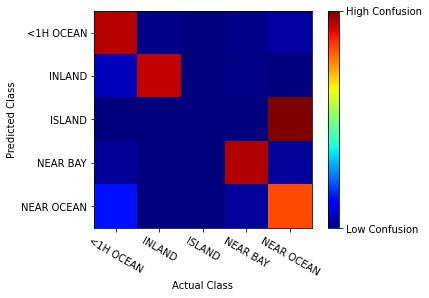

In [21]:
conf_mx = tf.math.confusion_matrix(y_test, y_pred.numpy()).numpy()

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
#np.fill_diagonal(norm_conf_mx, 0)
plt.imshow(norm_conf_mx, cmap = "jet")

cbar = plt.colorbar(ticks=[norm_conf_mx.min(), norm_conf_mx.max()])
cbar.ax.set_yticklabels(['Low Confusion', 'High Confusion'])
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class')

plt.xticks(np.arange(5), ("<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"), rotation=-30)
plt.yticks(np.arange(5), ("<1H OCEAN", "INLAND", "ISLAND", "NEAR BAY", "NEAR OCEAN"))

plt.show()

In [10]:
%load_ext tensorboard

In [13]:
%tensorboard --logdir logs/housing

Reusing TensorBoard on port 6006 (pid 9620), started 0:13:00 ago. (Use '!kill 9620' to kill it.)